## Differential equations

#### We use the following differential equations for the F and G radial functions for our electron wave function class.

$\begin{align} 
    \frac{dG}{dr_{*}} = (h - \mu \sqrt {1 - \frac {2M}{r}}) F - \frac{k}{r} \sqrt {1 - \frac {2M}{r}} G
\end{align}$

$\begin{align} 
    \frac{dF}{dr_{*}} = (-\mu \sqrt {1 - \frac {2M}{r}} - h) G + \frac{k}{r} \sqrt {1 - \frac {2M}{r}} F
\end{align}$

In [17]:
import numpy as np 
import math
import matplotlib.pyplot as plt 
from scipy import optimize
from scipy.optimize import fsolve

In [18]:
initial = 1
final = 20

step = 2

list1 = np.arange(initial, final, step)
list2 = np.flip(list1)
print((list1))
print(list2)
#print(np.flip(list1))

[ 1  3  5  7  9 11 13 15 17 19]
[19 17 15 13 11  9  7  5  3  1]


In [19]:
x = 1
y = 2
z = 3

arr = np.asarray([x,y,z])
print(type(arr))
print(arr)
print(arr[1])


(a, b, c) = tuple(2*arr)
print(a, b, c)

<class 'numpy.ndarray'>
[1 2 3]
2
2 4 6


In [48]:
class ElectronWaveFunction:
    
    """
    
    Electron Wave Function class implements the parameters and RK-4 method for the electron's radial part of the 
    wave function.
    
    
    Parameters
    ----------
    
    nu: float
    
    k: float
       quantum number 
    
    h: float
       Energy eigenvalue 
    
    
    mu: float
        mass of the electron
    
    
    lam: #NOTE: Do we even need this here?
    
    
    GC: float
        graviational constant, being set to 1 here
    
    c: float
       speed of light, set to 1 
    
    M: float
       mass of the blackhole
    
    
    tol: float
         tolerance level for various functions implemented 
         
         
         
    Methods
    -------
    
    r_to_r_star(r,M)
        Returns the corresponding value of r_star for a given r value
    
    r_star_to_r_condition(r_star, r, M)
        Returns the condition for the root solver used in the next funciton
        
    r_star_to_r(r_star, M, tol)
        Returns the corresponding r value for a given r_star value
        
    diff_equations(r_star, F, G)
        Returns the right hand side of the differential equations for the F and G radial functions
        
    RK_4(r_initial, r_final, N)
        Returns the set of F and G points after running the RK 4 method to solve the differential equations given 
        in the diff_equations() method. 
        
    """

    def __init__(self, nu, h, k, mu, M, lam, GC, c, tol):
        
        self.nu = nu
        self.k = k
        self.h = h
        self.mu = mu
        self.lam = lam
        self.GC = GC
        self.c = c
        self.M = M 
        self.tol = tol
     
    ###NOTE: Check both of these functions here, need to decide if it's r or r_star 
    def r_to_r_star(self, r, M):
        return r + 2*self.M*np.log((r - 2*self.M)/(2*self.M))

    
    def r_star_to_r_condition(self, r_star,r, M): 
        return  r_star -self.r_to_r_star(r, self.M) 
    
    
    def r_star_to_r(self, r_star, M, tol): #will need to replace all the local variables using self 

        if r_star > 12*self.M:

            r_prev = (2+1e-10)*self.M

            r_next = r_star - 2*self.M * np.log((r_prev - 2*self.M)/(2*self.M))
            
            #Counter for the while loop
            i = 0
            
            while abs((r_next - r_prev)/r_prev) > tol and i < 50: 

                i = i + 1

                r_prev = r_next

                r_next = r_star - 2*self.M * np.log((r_prev - 2*M)/(2*self.M))


            return r_next


        if r_star < -3*self.M: 

            r_prev = 2*self.M

            r_next = (2*self.M) * (1 + math.e**((r_star - r_prev) / (2*self.M)))

            i = 0

            while abs((r_next - r_prev)/r_prev) > tol and i < 50: 

                i = i + 1

                r_prev = r_next

                r_next = 2*self.M*(1 + math.e**((r_star - r_prev) / (2*self.M)))

            return r_next 


        else: 
            #r initial needs to be whatever r is for -10M = r_star, and same for r_final 

            r_initial = 2.1*self.M
            r_final = 10*self.M

            sol = optimize.root_scalar(lambda r: self.r_star_to_r_condition(r_star, r, self.M), bracket=[r_initial, r_final], method = 'brentq')

            return sol.root 




    #This function returns the differential equation    
    def diff_eq(self, r_star, F, G):
        
        #this is w.r.t. to r_star coordinate
        
        r = self.r_star_to_r(r_star, self.M, self.tol) #corresponding r value for the given r_star
        
        dG = ((self.h - self.mu * np.sqrt(1 - (2*self.M / r)))* F - 
            (self.k / r) * np.sqrt(1 - (2*self.M / r)) * G) 
        
        dF = ((-self.mu * np.sqrt(1 - (2*self.M / r)) - self.h) * G + 
            (self.k / r) * np.sqrt(1 - (2*self.M / r)) * F) 


        return np.asarray([dF, dG], dtype = np.complex)
    
    
    def RK_4(self, r_initial, r_final, N, up):
        
        #this is in terms of r_star

        step_size = (r_final - r_initial) / (N-1)
        
        r_points = np.linspace(r_initial, r_final, N)        
        
        #Define initial values for F and G
        
        if up == True:
            F = np.complex(np.sqrt(self.h + self.mu), 0)
            G = np.complex(0, -np.sqrt(self.h - self.mu))
            
        elif up == False: ###NOTE: this would be for the "in" funtions
            F = np.complex(1,0) ###NOTE: These are the eigenvalues for r_star -> -(infinity) 
            G = np.complex(0,1)
            
            #r_points = np.arange(r_initial, r_final, N)
        


        #Arrays to keep track of r, F and G points:

        F_points = []
        G_points = []
        
        
        for r in r_points:  
            #Update F_points and G_points arrays:
            F_points.append(F)
            G_points.append(G)


            #Calculate all the slopes (each variable has a separate k-slope):
            (k1F, k1G) = tuple(step_size * self.diff_eq(r, F, G))

            (k2F, k2G) = tuple(step_size * self.diff_eq(r + 0.5*step_size, F + 0.5*k1F, G + 0.5*k1G))

            (k3F, k3G) = tuple(step_size * self.diff_eq(r + 0.5*step_size, F + 0.5*k2F, G + 0.5*k2G))

            (k4F, k4G) = tuple(step_size * self.diff_eq(r + step_size, F + k3F, G + k3G))


            #Calculate next F_point and G_point
            F = F + (k1F + 2*k2F + 2*k3F + k4F) / 6
            G = G + (k1G + 2*k2G + 2*k3G + k4G) / 6

            
        return (r_points, F_points, G_points)
        
        
        
        

In [89]:
#Can use this class to initialize black holes for different values?

nu = 1.
k = 6.
h = 1.e-21
mu = 1.e-23 
lam = 1.
GC = 1.
M = 1.e21
c = 1.
tol = 1.e-10
try1 = ElectronWaveFunction(nu, h, k, mu, M, lam, GC, c, tol)

try_r = try1.r_star_to_r(-30*M, M, 1e-10)

In [90]:
r_initial = 10000.*M
r_final = -70.*M
r_points, F_points, G_points = try1.RK_4(r_initial, r_final, 240000, up = True)

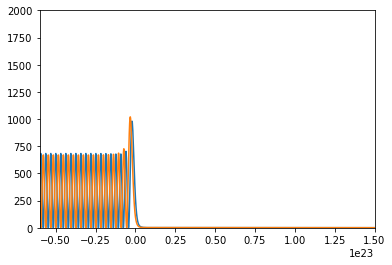

In [95]:
plt.xlim(-6e22,1.5e23)
plt.ylim(.0, 2000)
plt.plot(r_points, np.abs(G_points)**2 / (h-mu ))
plt.plot(r_points, np.abs(F_points)**2 / (h+mu ))
